In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.layers import Input, Dense
from sklearn.model_selection import KFold, StratifiedKFold
import joblib

In [2]:
train_set = pd.read_csv("./../Public_Datasets/UNSW_NB15_training-set.csv")
test_set = pd.read_csv("./../Public_Datasets/UNSW_NB15_testing-set.csv")

In [3]:
df = pd.DataFrame(pd.concat([train_set, test_set]))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [4]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [5]:
#Encoding categorical features
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


In [6]:
df.drop(['id', 'proto', 'state', 'service', 'attack_cat'], axis=1, inplace=True)

In [7]:
df.describe(include="all")

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [8]:
df.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,2,1,3,0,0,0,2,3,0,0


In [9]:
# Remove duplicates
df.drop_duplicates(inplace=True)
# Handle missing values
df.fillna(0, inplace=True)
# Remove missing values
df.dropna(inplace=True)

In [10]:
# Check for outliers and anomalies
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df_deep = df.copy()

In [11]:
df_deep

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,...,1,1,2,0,0,0,1,2,0,0
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,...,2,1,3,0,0,0,2,3,0,0
7,0.000028,2,0,1384,0,35714.285220,254,0,1.977143e+08,0.000000,...,1,1,3,0,0,0,1,3,0,0
16,0.000003,2,0,314,0,333333.321500,254,0,4.186667e+08,0.000000,...,1,1,2,0,0,0,1,2,0,0
21,0.000009,2,0,202,0,111111.107200,254,0,8.977778e+07,0.000000,...,1,1,2,0,0,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175182,2.724847,60,30,51667,2062,32.662383,62,252,1.491636e+05,5854.273438,...,1,1,1,0,0,0,1,1,0,1
175191,0.962856,24,60,1256,59374,86.201883,62,252,1.000357e+04,485098.500000,...,1,1,1,0,0,0,1,1,0,1
175299,0.996503,20,30,942,16684,49.171955,62,252,7.185126e+03,129476.781300,...,1,1,1,0,0,0,7,1,0,1
175305,1.557125,28,22,12601,1954,31.468251,62,252,6.242787e+04,9586.899414,...,1,1,2,0,0,0,2,1,0,1


In [12]:
df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,...,1,1,2,0,0,0,1,2,0,0
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,...,2,1,3,0,0,0,2,3,0,0
7,0.000028,2,0,1384,0,35714.285220,254,0,1.977143e+08,0.000000,...,1,1,3,0,0,0,1,3,0,0
16,0.000003,2,0,314,0,333333.321500,254,0,4.186667e+08,0.000000,...,1,1,2,0,0,0,1,2,0,0
21,0.000009,2,0,202,0,111111.107200,254,0,8.977778e+07,0.000000,...,1,1,2,0,0,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175182,2.724847,60,30,51667,2062,32.662383,62,252,1.491636e+05,5854.273438,...,1,1,1,0,0,0,1,1,0,1
175191,0.962856,24,60,1256,59374,86.201883,62,252,1.000357e+04,485098.500000,...,1,1,1,0,0,0,1,1,0,1
175299,0.996503,20,30,942,16684,49.171955,62,252,7.185126e+03,129476.781300,...,1,1,1,0,0,0,7,1,0,1
175305,1.557125,28,22,12601,1954,31.468251,62,252,6.242787e+04,9586.899414,...,1,1,2,0,0,0,2,1,0,1


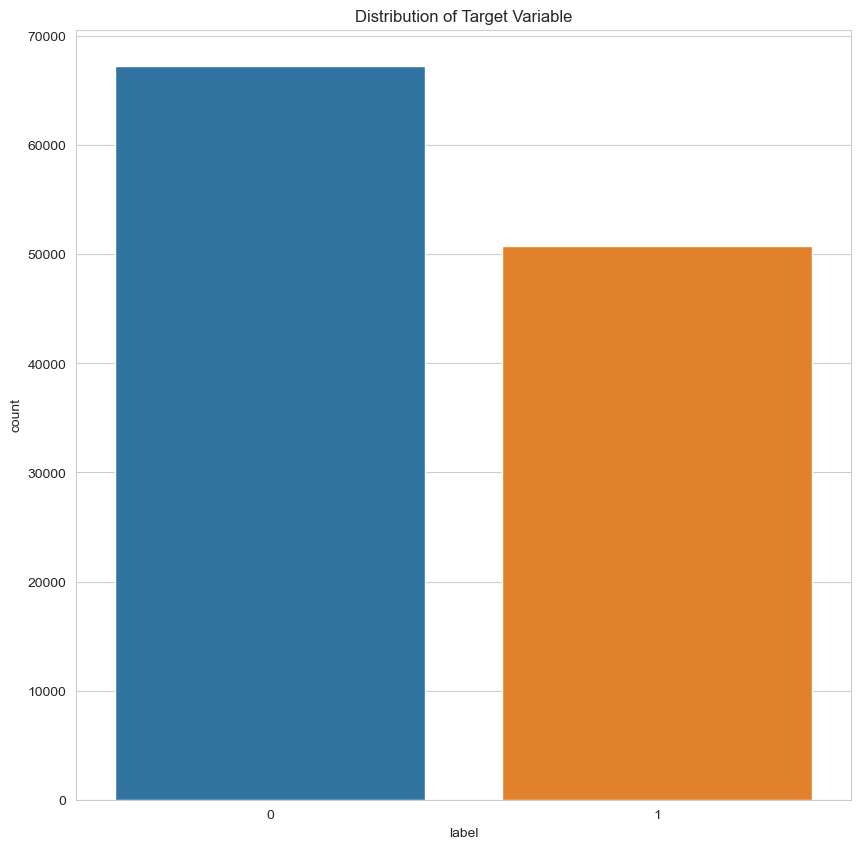

In [13]:
# Distribution of target variable
plt.figure(figsize=(10, 10))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable')
plt.savefig('./../plot/distribution_of_target_variable.png', dpi=200)
plt.show()

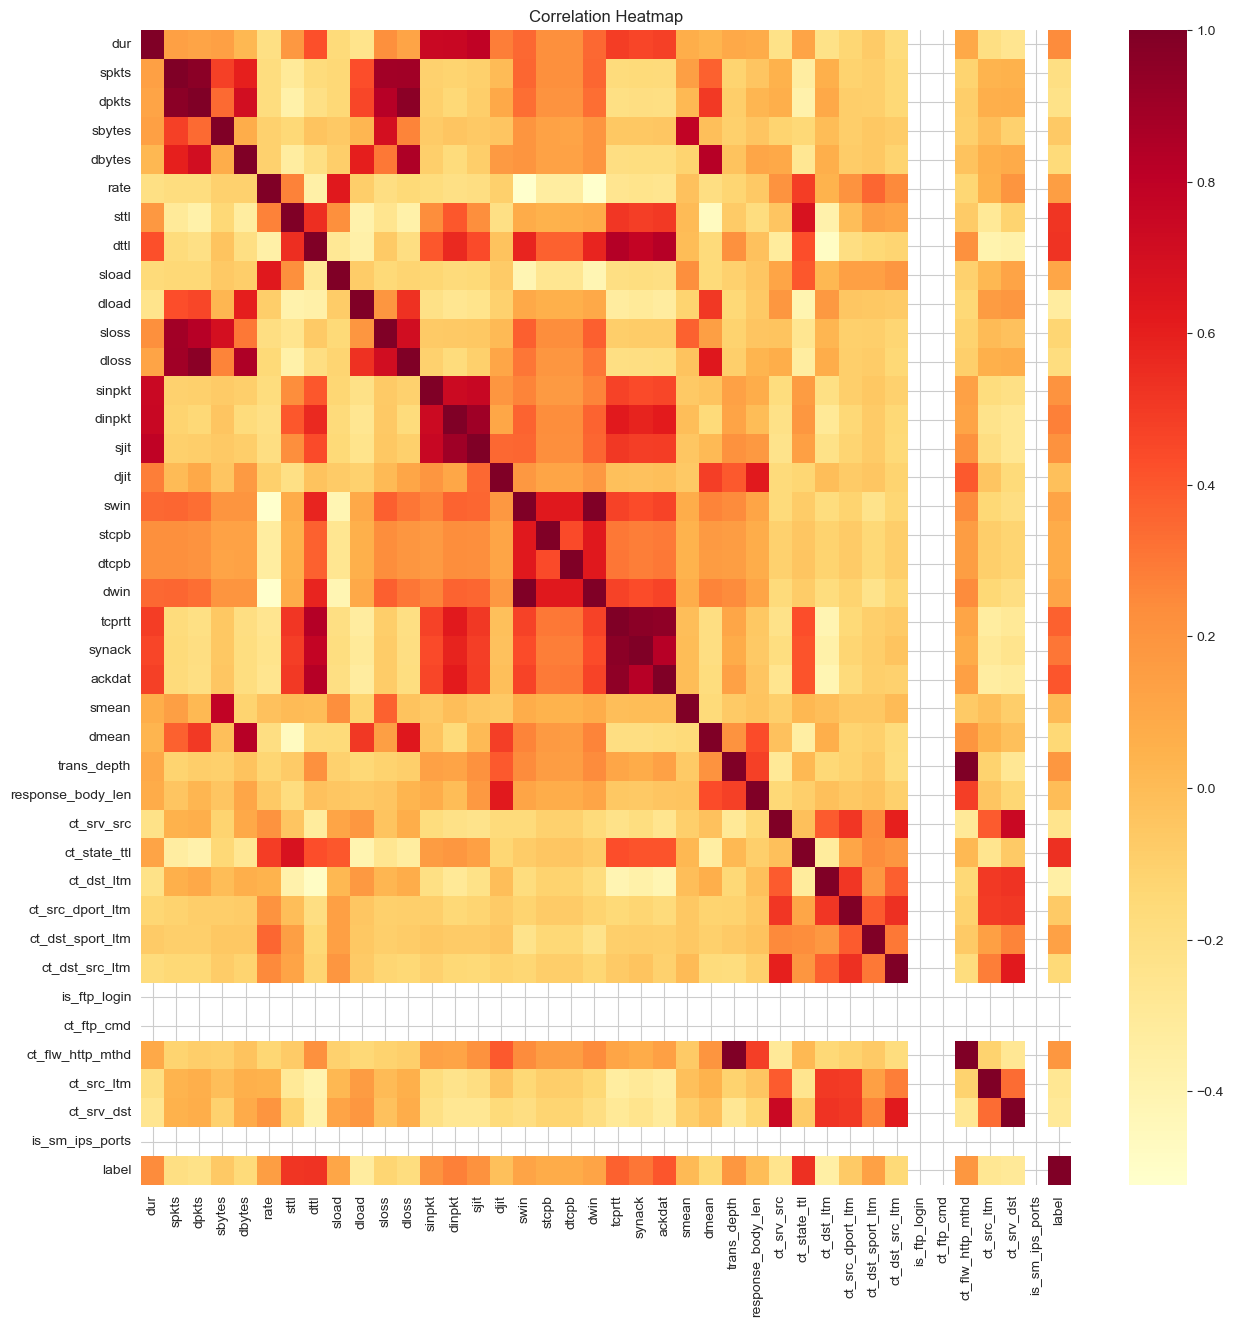

In [14]:
# Correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), fmt='d', cmap='YlOrRd')
plt.title('Correlation Heatmap')
plt.savefig('./../plot/correlation_heatmap.png', dpi=200)
plt.show()

In [15]:
# # Pair plot
# sns.pairplot(df, hue='label')
# plt.title('Pair plot')
# plt.show()

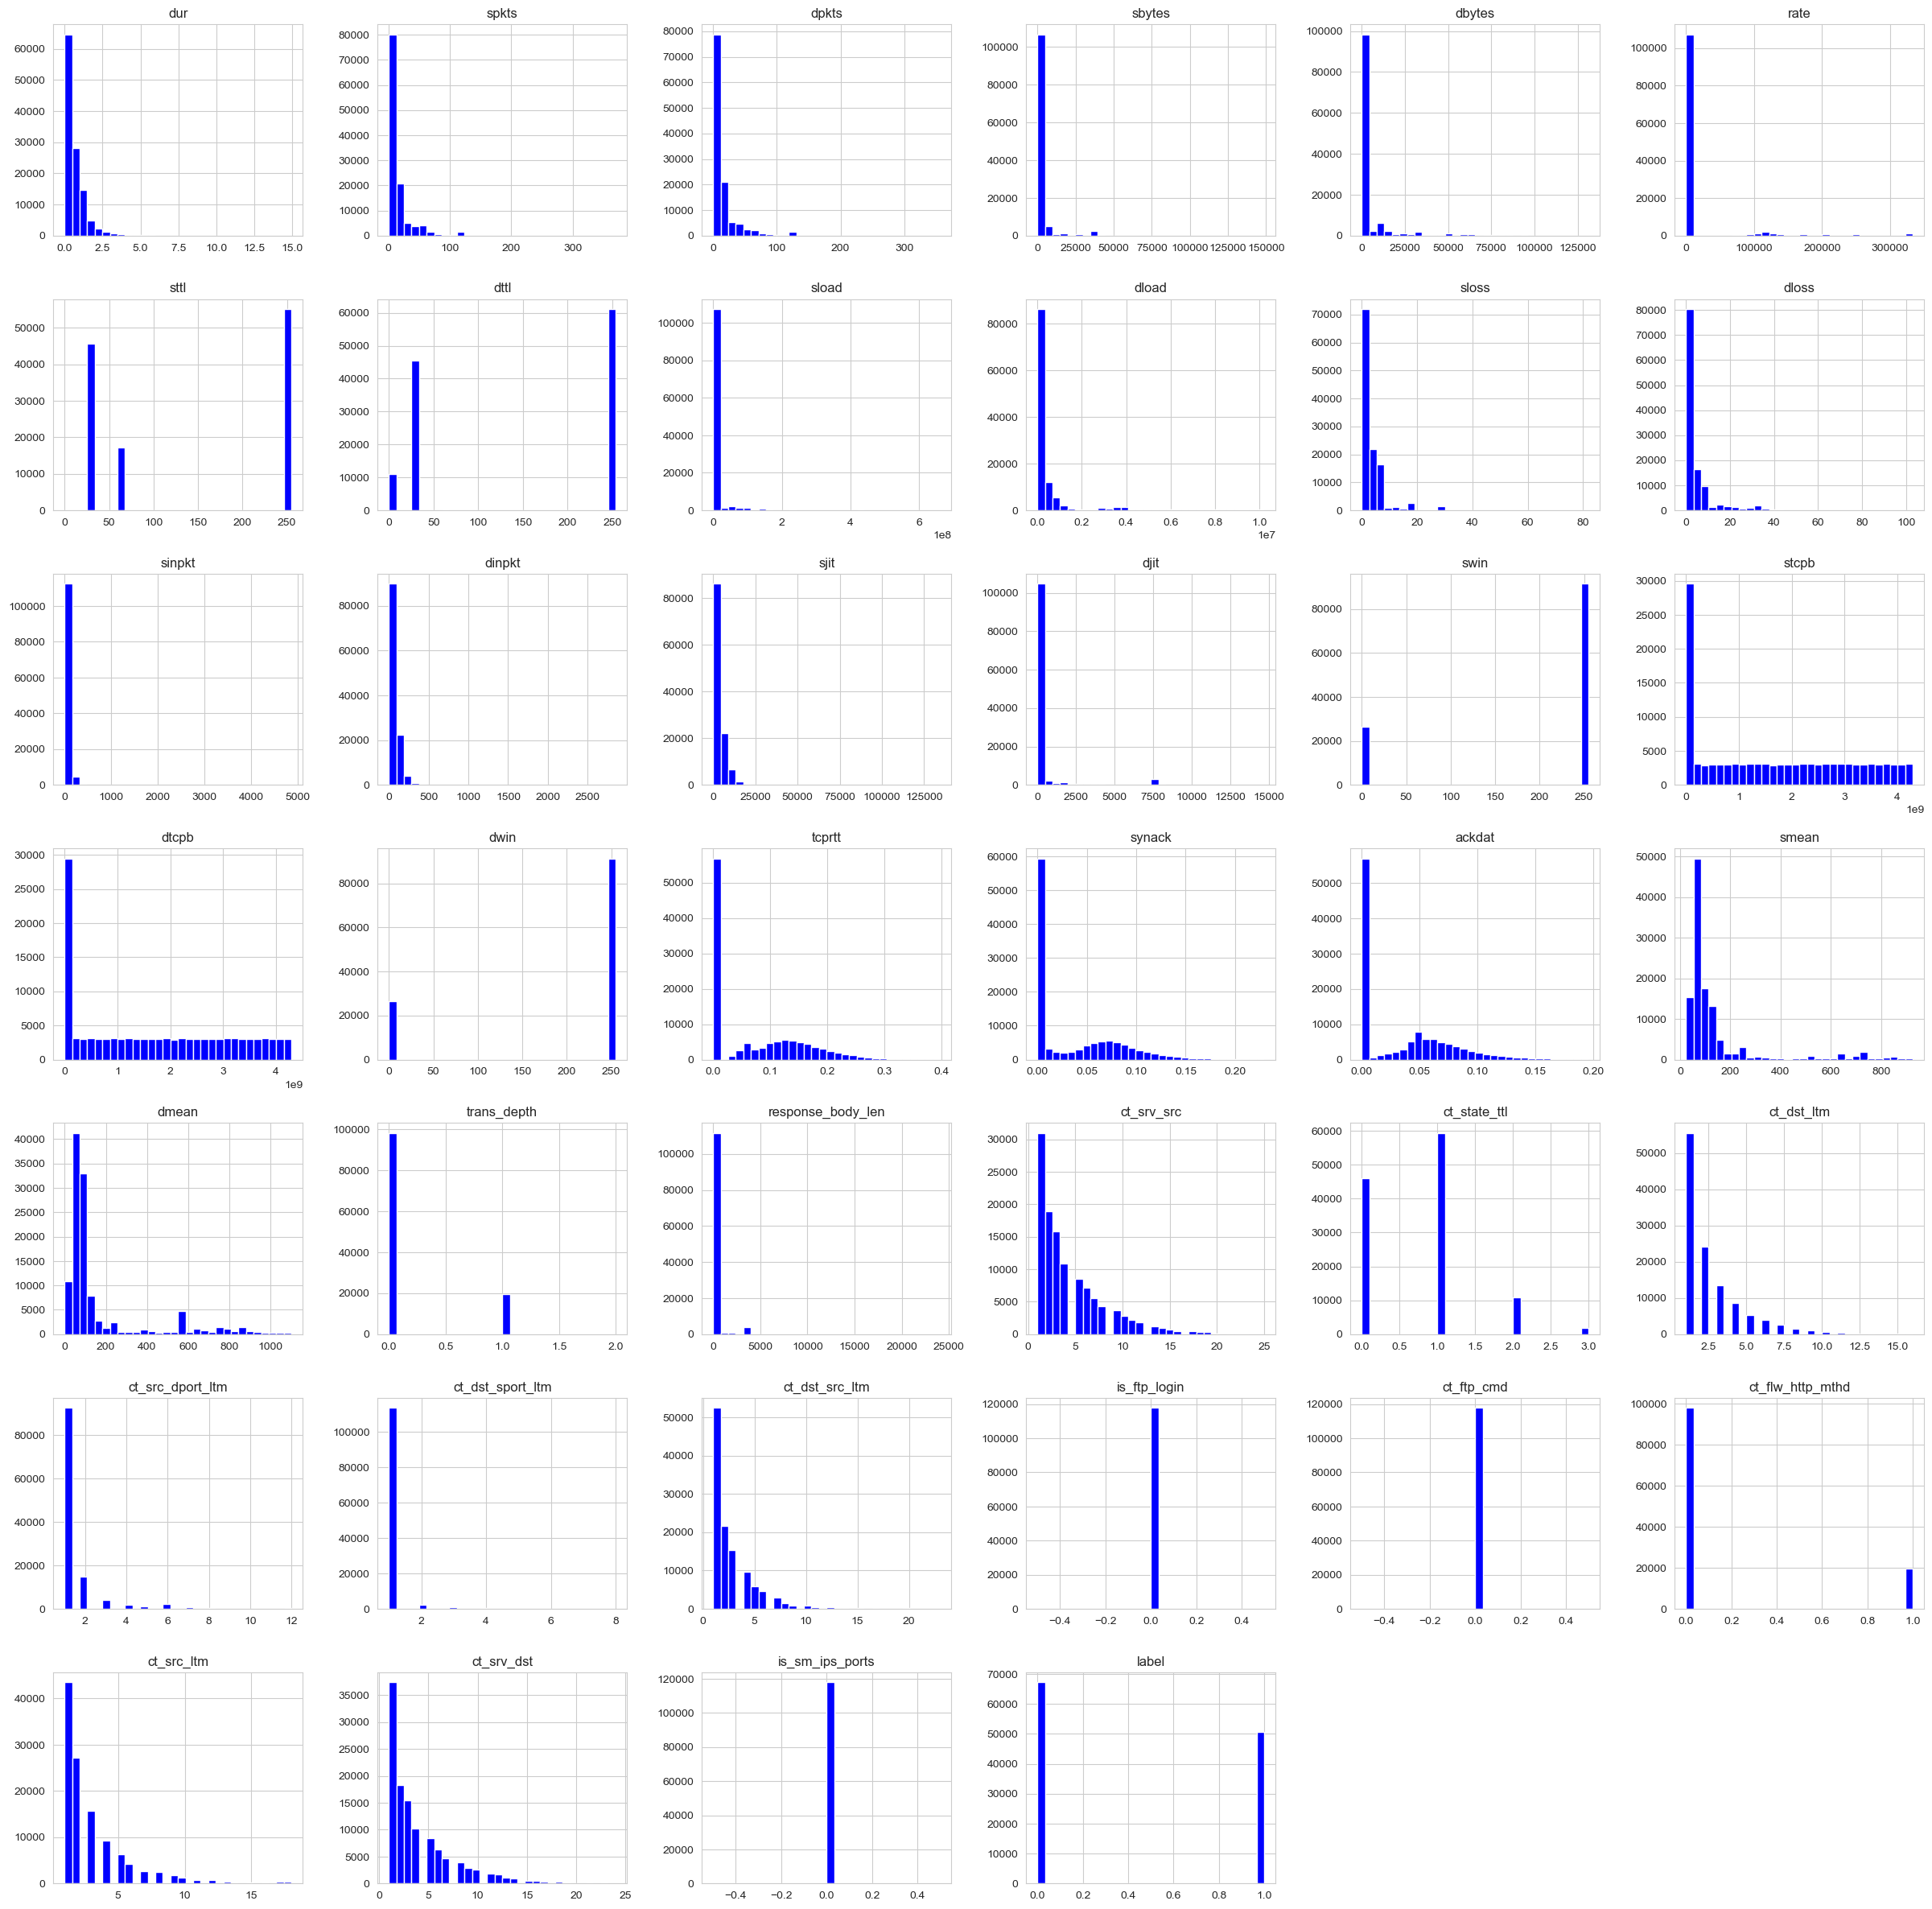

In [16]:
# Distribution of numerical variables
df.hist(bins=30, color='b', figsize=(30,30))
plt.savefig('./../plot/hist.png', dpi=200)
plt.show()

In [17]:
# Create new features
df['src_bytes_dst_bytes'] = df['sbytes'] + df['dbytes']
df['src_pkts_dst_pkts'] = df['spkts'] + df['dpkts']
df['src_bytes_per_pkt'] = df['sbytes'] / df['spkts']
df['dst_bytes_per_pkt'] = df['dbytes'] / df['dpkts']

In [18]:
# Split the data into features and target variable
X = df.drop('label', axis=1)
y = df['label']

In [19]:
X['dst_bytes_per_pkt'].fillna(value=X['dst_bytes_per_pkt'].mean(), inplace=True)

In [20]:
# Select the 25 most important features
skb = SelectKBest(chi2, k=25)
X_skb = skb.fit_transform(X, y)

In [21]:
# Split the data into training, validation and testing sets for filter method
X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_skb, y, test_size=0.15, random_state=42)
X_train_filter, X_val_filter, y_train_filter, y_val_filter = train_test_split(X_train_filter, y_train_filter, test_size=0.15, random_state=42)

In [22]:
# Build the model using logistic method
model_logistic = LogisticRegression(random_state=42, max_iter=100)
model_logistic.fit(X_train_filter, y_train_filter)

LogisticRegression(random_state=42)

In [23]:
# Build the model using model_RFC_filter method
model_RFC_filter = RandomForestClassifier(n_estimators=200, random_state=42)
model_RFC_filter.fit(X_train_filter, y_train_filter)

RandomForestClassifier(n_estimators=200, random_state=42)

In [24]:
model_wrapper = RandomForestClassifier(n_estimators=200, random_state=42)
rfe = RFE(model_wrapper, n_features_to_select=25, verbose=1)
X_rfe = rfe.fit_transform(X, y)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


In [25]:
# Split the data into training, validation and testing sets for Wrapper method
X_train_wrapper, X_test_wrapper, y_train_wrapper, y_test_wrapper = train_test_split(X_rfe, y, test_size=0.15, random_state=42)
X_train_wrapper, X_val_wrapper, y_train_wrapper, y_val_wrapper = train_test_split(X_train_wrapper, y_train_wrapper, test_size=0.15, random_state=42)

In [26]:
# Build the model using model_RFC_wrapper method
model_wrapper.fit(X_train_wrapper, y_train_wrapper)

RandomForestClassifier(n_estimators=200, random_state=42)

In [27]:
#Saving Logistic Model
save_model_logistic = "../model/Logistic_Regression_Model.h5"
joblib.dump(model_logistic, save_model_logistic)
#Saving Model RFC Model
save_model_RFC_filter = "../model/Random_Forest_Model_With_Filter_Method.h5"
joblib.dump(model_RFC_filter, save_model_RFC_filter)
#Saving Model RFC Model with RFE
save_model_RFC_wrapper = "../model/Random_Forest_Model_With_Wrapper_Method.h5"
joblib.dump(model_wrapper, save_model_RFC_wrapper)

['../model/Random_Forest_Model_With_Wrapper_Method.h5']

In [28]:
#Load Logistic Model
logistic_model = joblib.load(save_model_logistic)
#Load Model RFC Model with filter
filter_model_RFC = joblib.load(save_model_RFC_filter)
#Load RFC Model with RFE
wrapper_model_RFC = joblib.load(save_model_RFC_wrapper)

In [29]:
#Logistic Model

In [30]:
# Cross-validation
scores = cross_val_score(logistic_model, X_val_filter, y_val_filter, cv=25)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.70265781 0.75913621 0.70431894 0.75083056 0.73421927 0.72923588
 0.67774086 0.72259136 0.72425249 0.72093023 0.73089701 0.74584718
 0.72425249 0.71760797 0.73089701 0.73089701 0.75207987 0.76039933
 0.72712146 0.71547421 0.69717138 0.74209651 0.7171381  0.76039933
 0.72545757]
Mean cross-validation score: 0.72814600250966


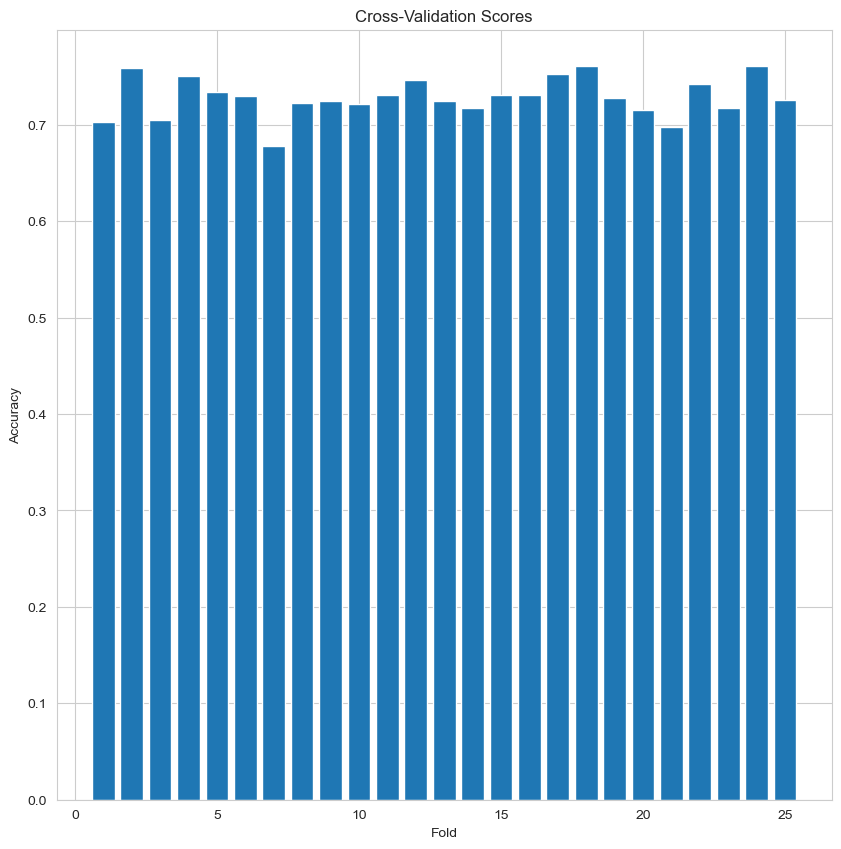

In [31]:
# Plot the cross-validation scores
plt.figure(figsize=(10, 10))
plt.bar(range(1, 26), scores)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.savefig('./../plot/cross_validation_logistic_model.png', dpi=200)
plt.show()

In [32]:
# Make predictions on the test set
logistic_pre = logistic_model.predict(X_test_filter)

# Calculate the accuracy of the model
logistic_accuracy = accuracy_score(y_test_filter, logistic_pre)
print('Accuracy:', logistic_accuracy)

Accuracy: 0.7293173598553345


Confusion Matrix:
 [[6093 4122]
 [ 668 6813]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72     10215
           1       0.62      0.91      0.74      7481

    accuracy                           0.73     17696
   macro avg       0.76      0.75      0.73     17696
weighted avg       0.78      0.73      0.73     17696



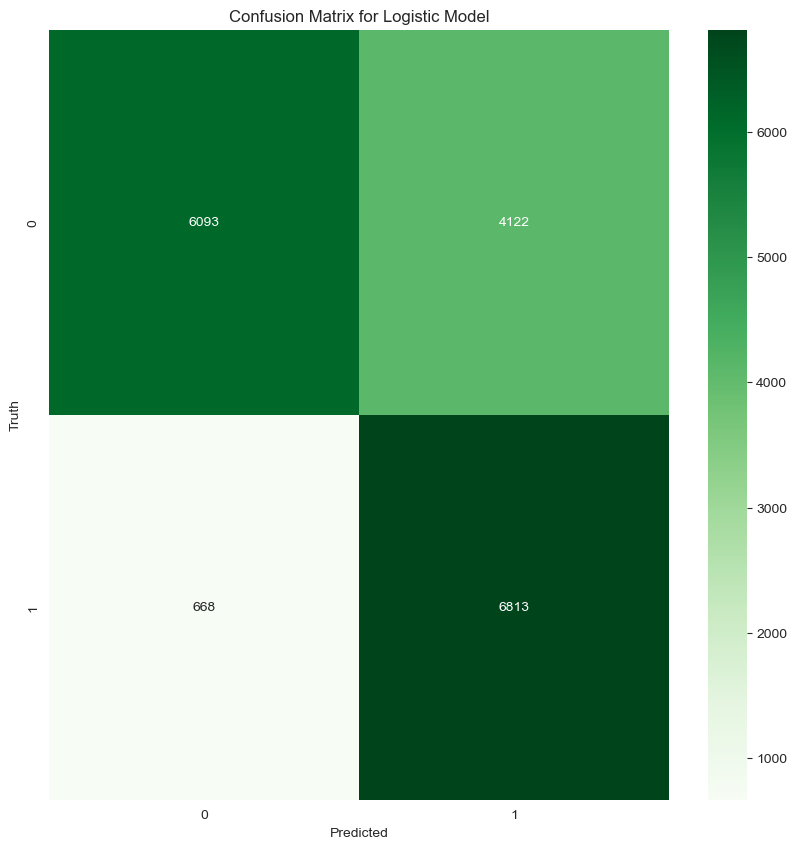

In [33]:
# Print the confusion matrix and classification report
print('Confusion Matrix:\n', confusion_matrix(y_test_filter, logistic_pre))
print('Classification Report:\n', classification_report(y_test_filter, logistic_pre))
logistic_cm = confusion_matrix(y_test_filter, logistic_pre, labels=logistic_model.classes_)
plt.figure(figsize=(10, 10))
sns.heatmap(logistic_cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Logistic Model')
plt.savefig('./../plot/confusion_matrix_logistic_model.png', dpi=200)
plt.show()

0.4425285293688457


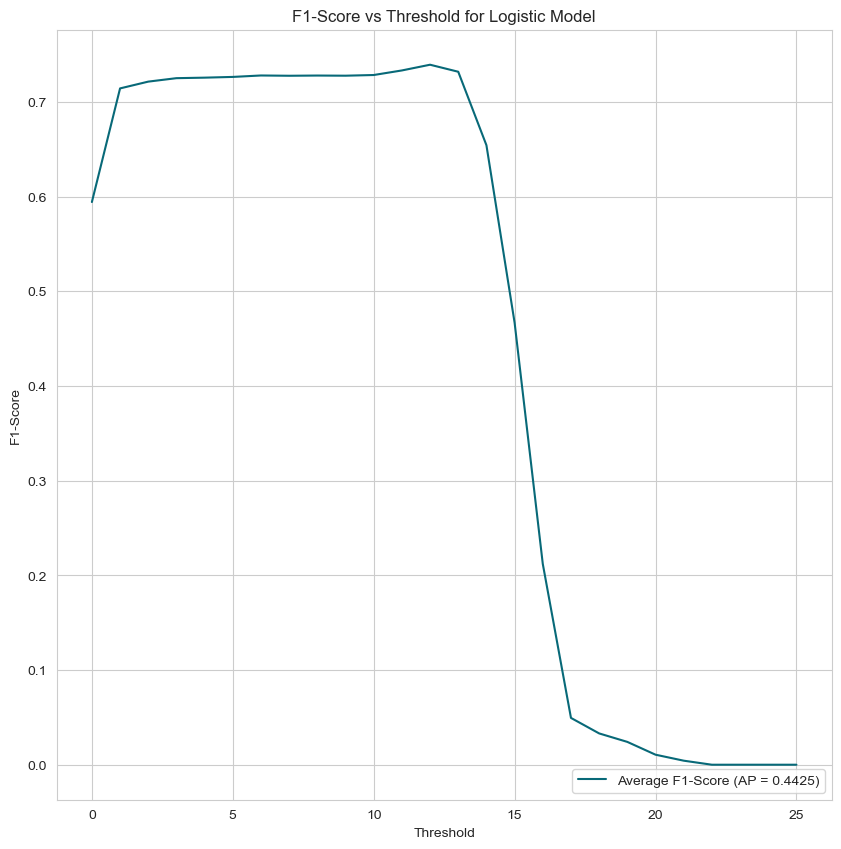

In [34]:
# Calculate the F1-score for different threshold values
logistic_f1_scores = []
logistic_thresholds = range(0, 26)
for logistic_threshold in logistic_thresholds:
    logistic_y_pred_threshold = (logistic_model.predict_proba(X_test_filter)[:, 1] >= logistic_threshold/25).astype(int)
    logistic_f1_scores.append(f1_score(y_test_filter, logistic_y_pred_threshold))

# Plot the F1-score for different threshold values
logistic_ave_f1_score = np.mean(logistic_f1_scores)
print(logistic_ave_f1_score)
plt.figure(figsize=(10, 10))
plt.plot(logistic_thresholds, logistic_f1_scores , color='#086978', label='Average F1-Score (AP = %0.4f)' % logistic_ave_f1_score)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for Logistic Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/f1_score_logistic_model.png', dpi=200)
plt.show()

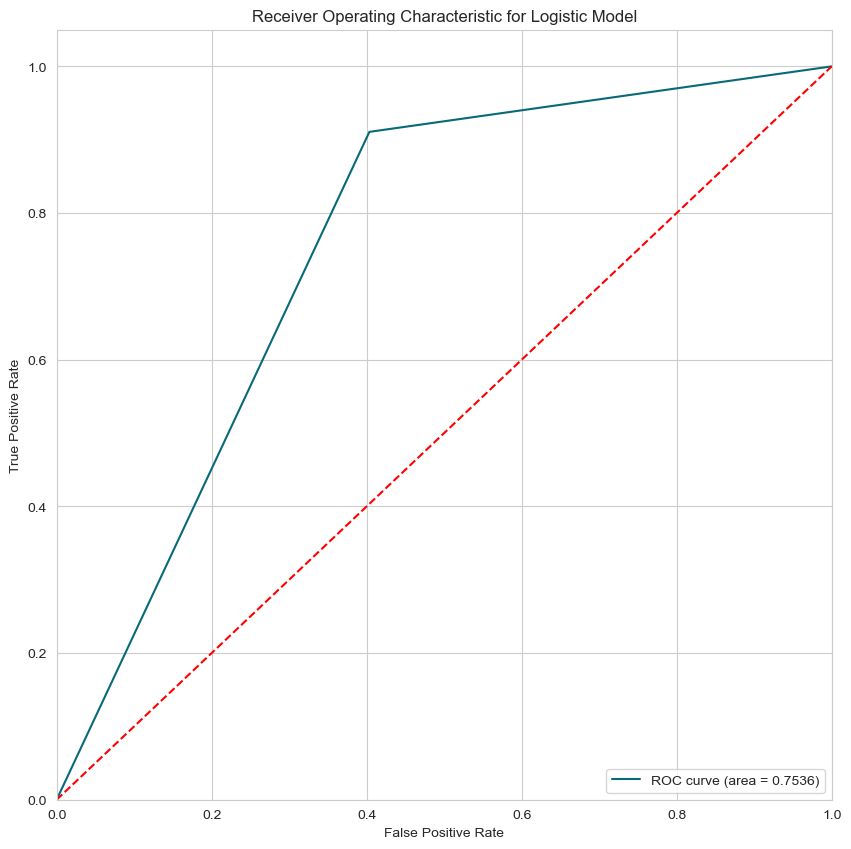

In [35]:
#Model Evaluation
# Calculate the ROC curve and AUC score
logistic_fpr, logistic_tpr, logistic_thresholds_roc = roc_curve(y_test_filter, logistic_pre)
logistic_roc_auc = auc(logistic_fpr, logistic_tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(logistic_fpr, logistic_tpr, color='#086978', label='ROC curve (area = %0.4f)' % logistic_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/ROC_logistic_model.png', dpi=200)
plt.show()

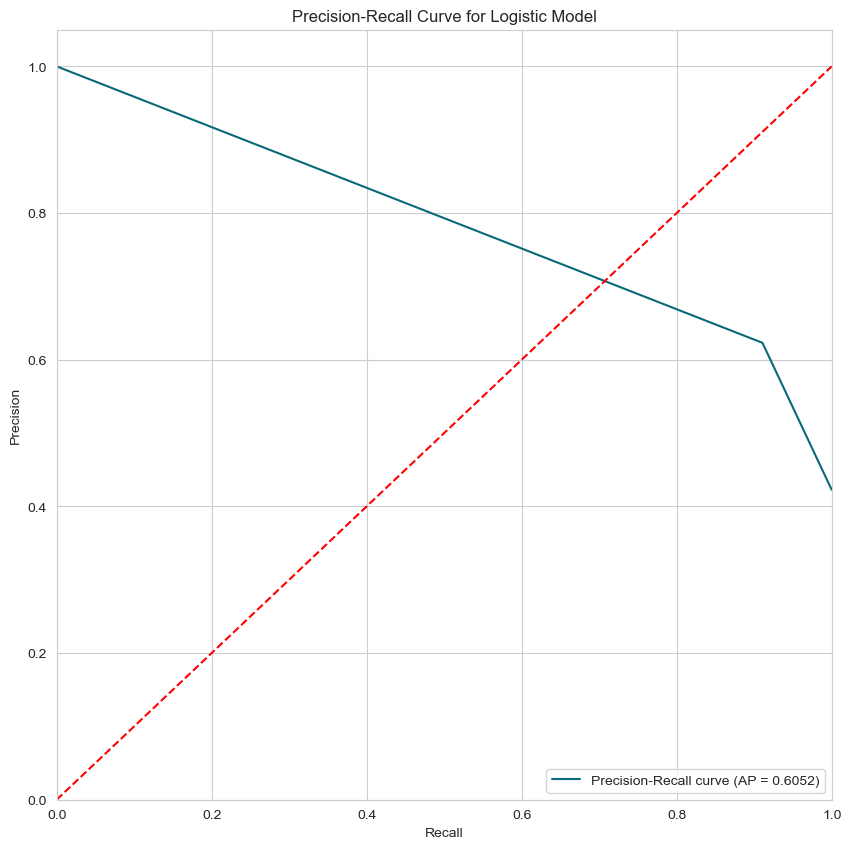

In [36]:
# Calculate the precision-recall curve and average precision score
logistic_precision, logistic_recall, logistic_thresholds_precision_recall = precision_recall_curve(y_test_filter, logistic_pre)
logistic_average_precision = average_precision_score(y_test_filter, logistic_pre)

# Plot the precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(logistic_recall, logistic_precision, color='#086978', label='Precision-Recall curve (AP = %0.4f)' % logistic_average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve for Logistic Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/precision_recall_curve_logistic_model.png', dpi=200)
plt.show()

In [37]:
#Random Forest With Filter Method

In [38]:
# Cross-validation
scores_filter = cross_val_score(filter_model_RFC, X_val_filter, y_val_filter, cv=25)
print('Cross-validation scores:', scores_filter)
print('Mean cross-validation score:', scores_filter.mean())

Cross-validation scores: [0.87375415 0.8986711  0.8986711  0.90697674 0.88704319 0.89368771
 0.8986711  0.89202658 0.89700997 0.89036545 0.91694352 0.87375415
 0.89534884 0.88870432 0.88870432 0.88538206 0.89351082 0.89018303
 0.88851913 0.91680532 0.86189684 0.89517471 0.89184692 0.921797
 0.88519135]
Mean cross-validation score: 0.8932255764202519


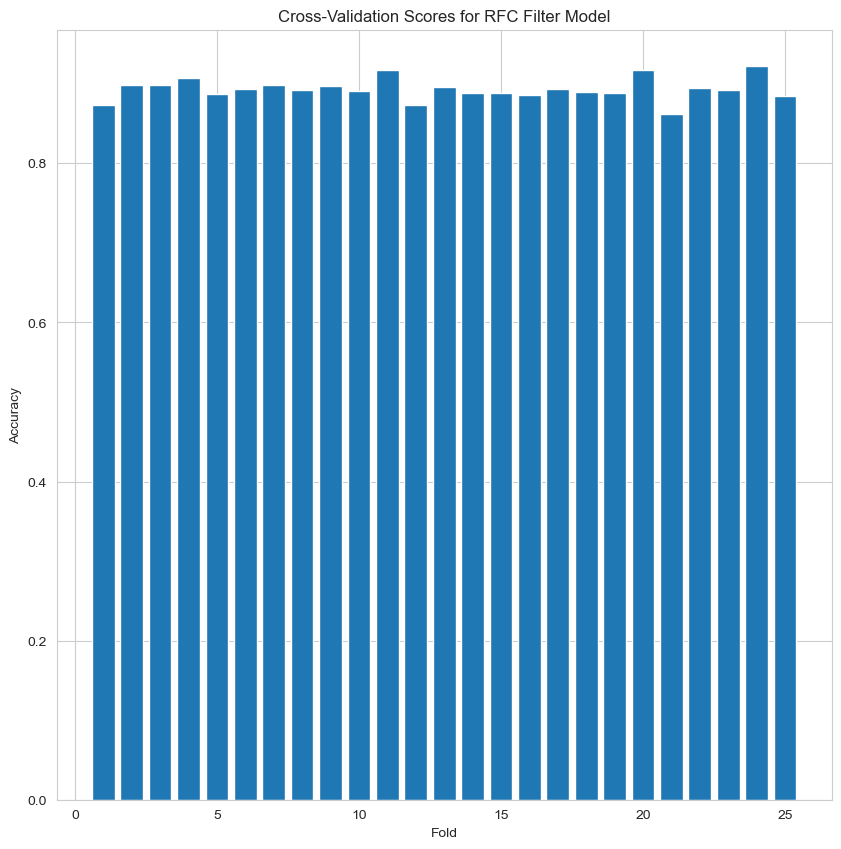

In [39]:
# Plot the cross-validation scores
plt.figure(figsize=(10, 10))
plt.bar(range(1, 26), scores_filter)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for RFC Filter Model')
plt.savefig('./../plot/cross_validation_RFC_filter_model.png', dpi=200)
plt.show()

In [40]:
# Make predictions on the test set
pre_filter = filter_model_RFC.predict(X_test_filter)

# Calculate the accuracy of the model
accuracy_filter = accuracy_score(y_test_filter, pre_filter)
print('Accuracy:', accuracy_filter)

Accuracy: 0.8993557866184448


Confusion Matrix:
 [[9392  823]
 [ 958 6523]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     10215
           1       0.89      0.87      0.88      7481

    accuracy                           0.90     17696
   macro avg       0.90      0.90      0.90     17696
weighted avg       0.90      0.90      0.90     17696



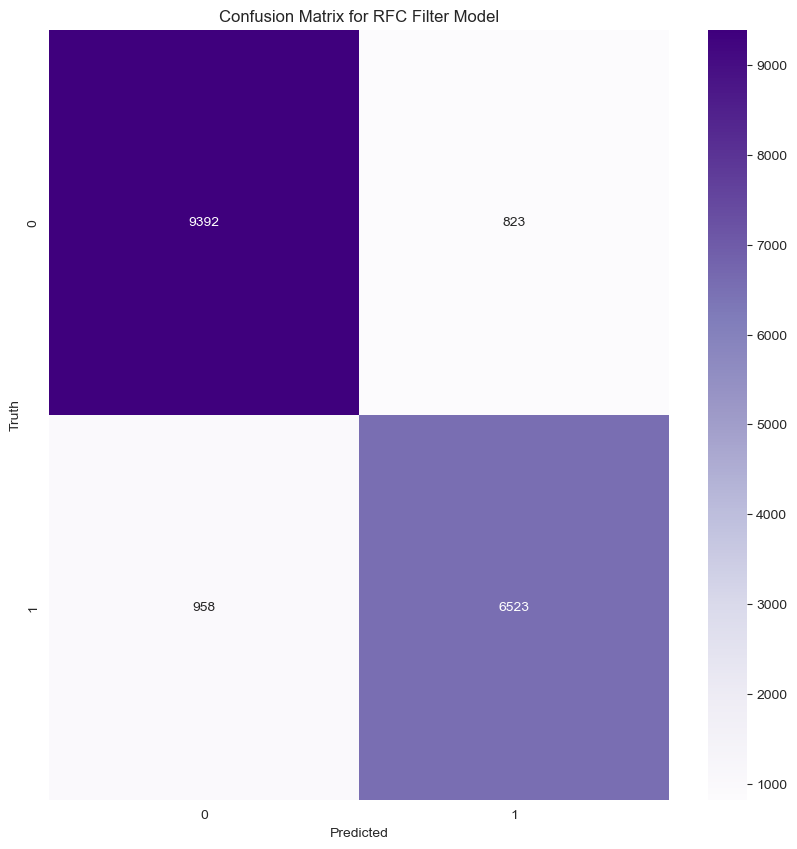

In [41]:
# Print the confusion matrix and classification report
print('Confusion Matrix:\n', confusion_matrix(y_test_filter, pre_filter))
print('Classification Report:\n', classification_report(y_test_filter, pre_filter))
cm_filter = confusion_matrix(y_test_filter, pre_filter, labels=filter_model_RFC.classes_)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_filter, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for RFC Filter Model')
plt.savefig('./../plot/confusion_matrix_RFC_filter_model.png', dpi=200)
plt.show()

0.8212654979416256


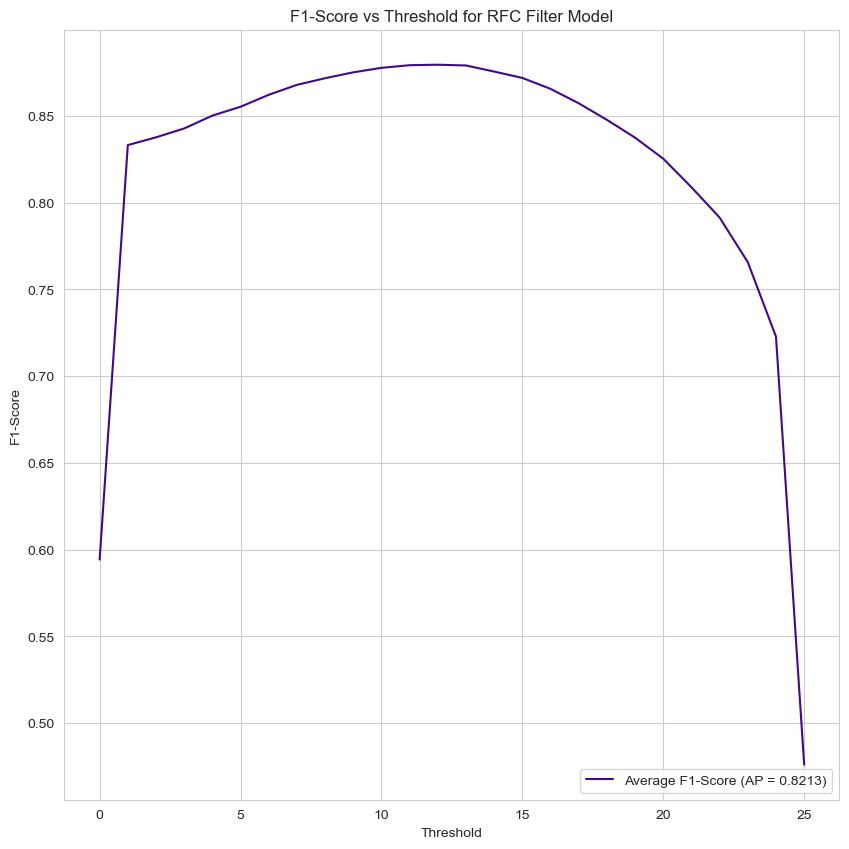

In [42]:
# Calculate the F1-score for different threshold values
f1_scores_filter = []
thresholds_filter = range(0, 26)
for threshold_filter in thresholds_filter:
    y_pred_threshold_filter = (filter_model_RFC.predict_proba(X_test_filter)[:, 1] >= threshold_filter/25).astype(int)
    f1_scores_filter.append(f1_score(y_test_filter, y_pred_threshold_filter))

# Plot the F1-score for different threshold values
ave_f1_score_filter = np.mean(f1_scores_filter)
print(ave_f1_score_filter)
plt.figure(figsize=(10, 10))
plt.plot(thresholds_filter, f1_scores_filter , color='#430887',  label='Average F1-Score (AP = %0.4f)' % ave_f1_score_filter)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for RFC Filter Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/f1_score_RFC_filter_model.png', dpi=200)
plt.show()

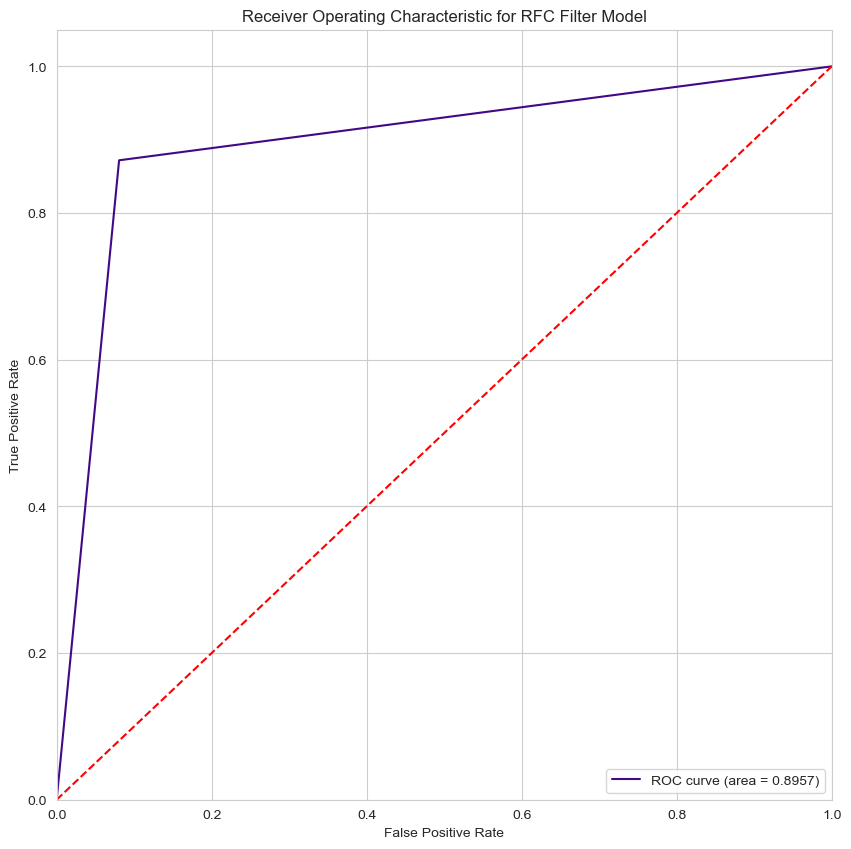

In [43]:
#Model Evaluation
# Calculate the ROC curve and AUC score
fpr_filter, tpr_filter, thresholds_roc_filter = roc_curve(y_test_filter, pre_filter)
roc_auc_filter = auc(fpr_filter, tpr_filter)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_filter, tpr_filter, color='#430887',  label='ROC curve (area = %0.4f)' % roc_auc_filter)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RFC Filter Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/ROC_RFC_filter_model.png', dpi=200)
plt.show()

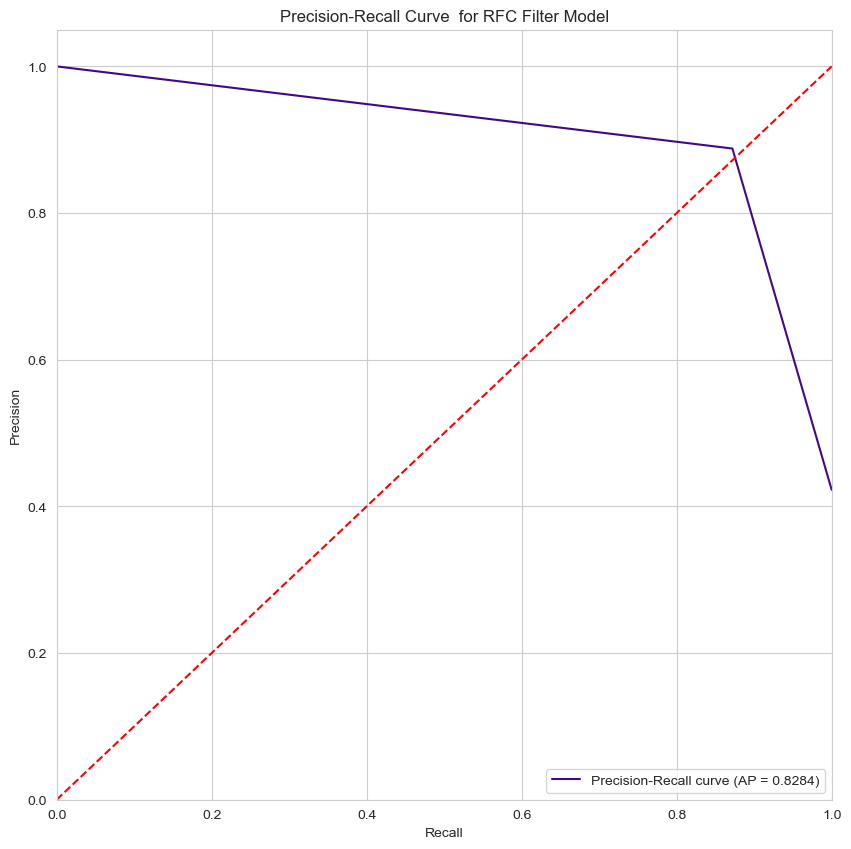

In [44]:
# Calculate the precision-recall curve and average precision score
precision_filter, recall_filter, thresholds_precision_recall_filter = precision_recall_curve(y_test_filter, pre_filter)
average_precision_filter = average_precision_score(y_test_filter, pre_filter)

# Plot the precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(recall_filter, precision_filter, color='#430887',  label='Precision-Recall curve (AP = %0.4f)' % average_precision_filter)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve  for RFC Filter Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/precision_recall_curve_RFC_filter_model.png', dpi=200)
plt.show()

In [45]:
#Random Forest With Wrapper Method

In [46]:
# Cross-validation
scores_wrapper = cross_val_score(wrapper_model_RFC, X_val_wrapper, y_val_wrapper, cv=25)
print('Cross-validation scores:', scores_wrapper)
print('Mean cross-validation score:', scores_wrapper.mean())

Cross-validation scores: [0.88538206 0.90365449 0.91362126 0.91362126 0.88538206 0.91196013
 0.90199336 0.91362126 0.90199336 0.90531561 0.92026578 0.88870432
 0.90697674 0.90531561 0.90697674 0.89700997 0.91347754 0.89184692
 0.91514143 0.91014975 0.88019967 0.90682196 0.91680532 0.921797
 0.8968386 ]
Mean cross-validation score: 0.9045948889171426


In [47]:
# Make predictions on the test set
pre_wrapper = wrapper_model_RFC.predict(X_test_wrapper)
# Calculate the accuracy of the model
accuracy_wrapper = accuracy_score(y_test_wrapper, pre_wrapper)
print('Accuracy:', accuracy_wrapper)

Accuracy: 0.9091885171790235


Confusion Matrix:
 [[9473  742]
 [ 865 6616]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92     10215
           1       0.90      0.88      0.89      7481

    accuracy                           0.91     17696
   macro avg       0.91      0.91      0.91     17696
weighted avg       0.91      0.91      0.91     17696



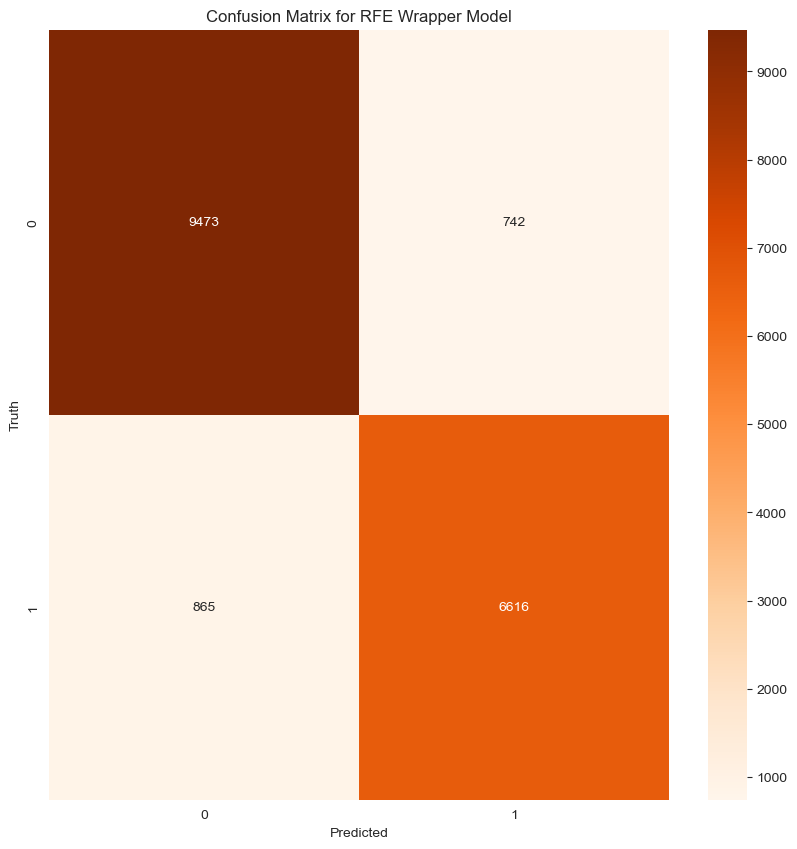

In [48]:
# Print the confusion matrix and classification report
print('Confusion Matrix:\n', confusion_matrix(y_test_wrapper, pre_wrapper))
print('Classification Report:\n', classification_report(y_test_wrapper, pre_wrapper))
cm = confusion_matrix(y_test_wrapper, pre_wrapper, labels=wrapper_model_RFC.classes_)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for RFE Wrapper Model')
plt.savefig('./../plot/confusion_matrix_RFC_wrapper_model.png', dpi=200)
plt.show()

0.834094666870501


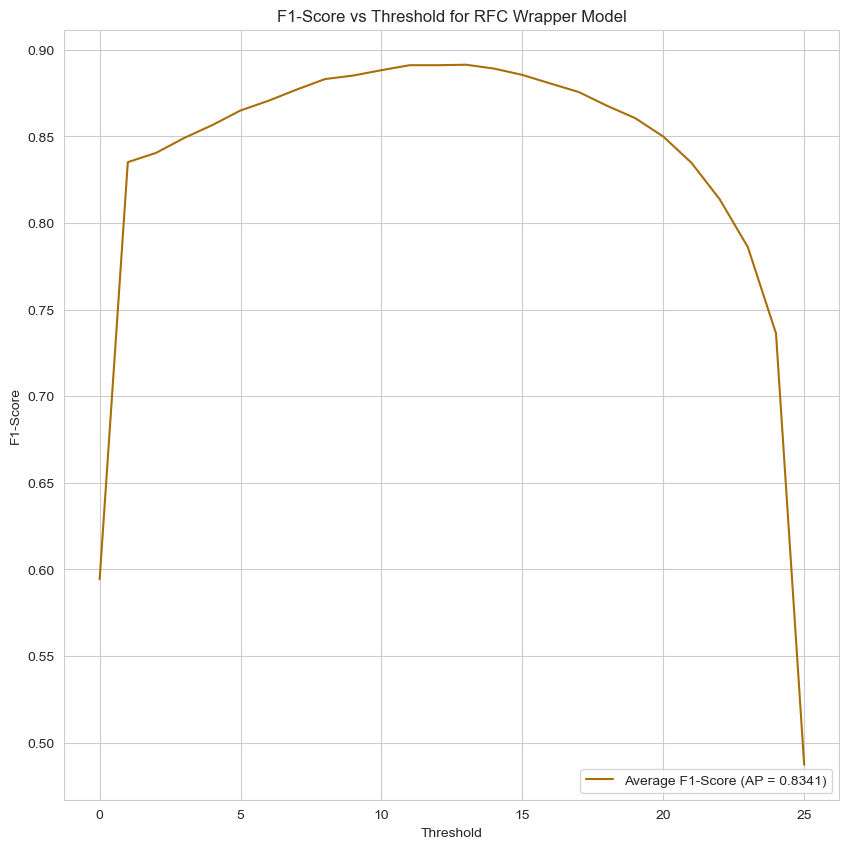

In [49]:
# Calculate the F1-score for different threshold values
f1_scores_wrapper = []
thresholds_wrapper = range(0, 26)
for threshold_wrapper in thresholds_wrapper:
    y_pred_threshold_wrapper = (wrapper_model_RFC.predict_proba(X_test_wrapper)[:, 1] >= threshold_wrapper/25).astype(int)
    f1_scores_wrapper.append(f1_score(y_test_wrapper, y_pred_threshold_wrapper))

# Plot the F1-score for different threshold values
ave_f1_score_wrapper = np.mean(f1_scores_wrapper)
print(ave_f1_score_wrapper)
plt.figure(figsize=(10, 10))
plt.plot(thresholds_wrapper, f1_scores_wrapper, color='#a86e0a',  label='Average F1-Score (AP = %0.4f)' % ave_f1_score_wrapper)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for RFC Wrapper Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/F1_score_RFC_wrapper_model.png', dpi=200)
plt.show()

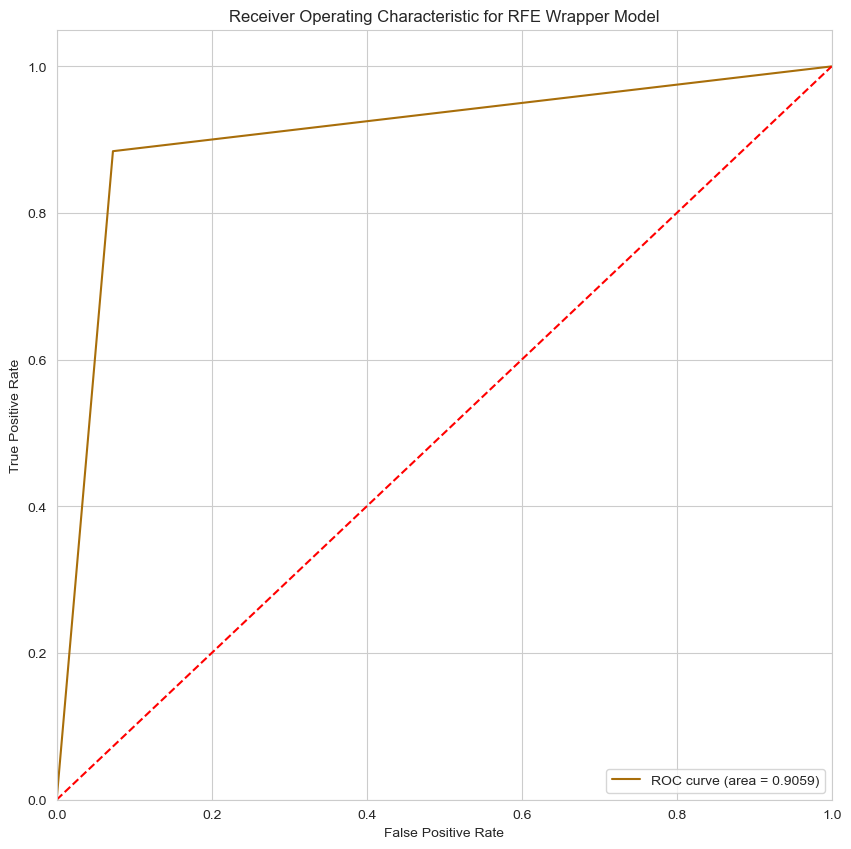

In [50]:
# Calculate the ROC curve and AUC score
fpr_wrapper, tpr_wrapper, thresholds_roc_wrapper = roc_curve(y_test_wrapper, pre_wrapper)
roc_auc_wrapper = auc(fpr_wrapper, tpr_wrapper)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_wrapper, tpr_wrapper, color='#a86e0a',  label='ROC curve (area = %0.4f)' % roc_auc_wrapper)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RFE Wrapper Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/ROC_RFC_wrapper_model.png', dpi=200)
plt.show()


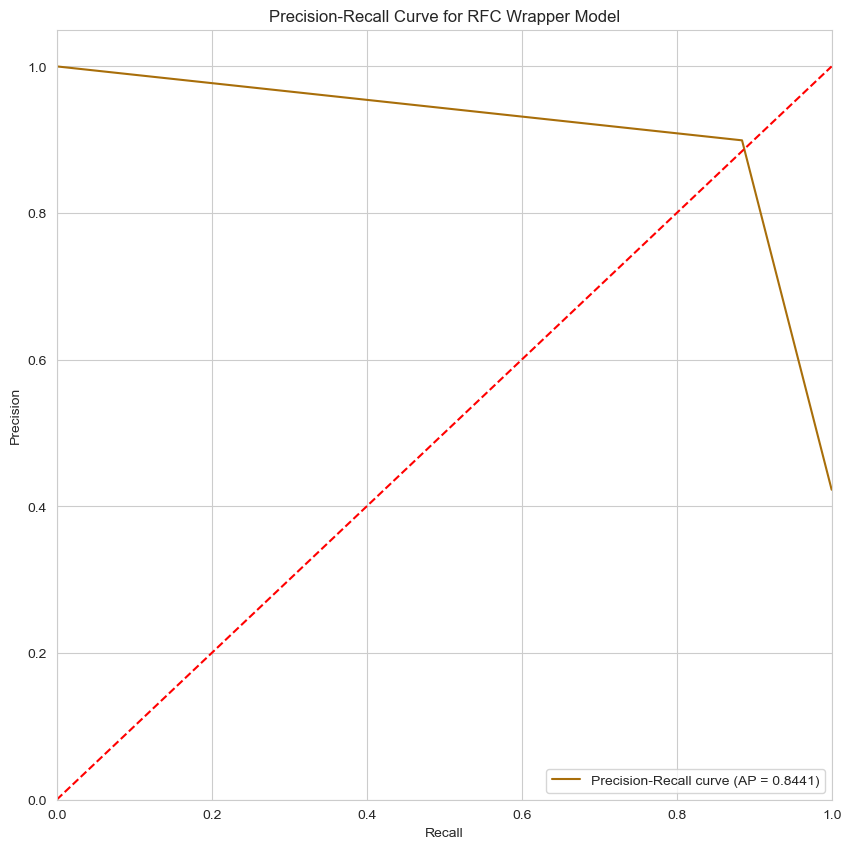

In [51]:
# Calculate the precision-recall curve and average precision score
precision_wrapper, recall_wrapper, thresholds_precision_recall_wrapper = precision_recall_curve(y_test_wrapper, pre_wrapper)
average_precision_wrapper = average_precision_score(y_test_wrapper, pre_wrapper)

# Plot the precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(recall_wrapper, precision_wrapper, color='#a86e0a', label='Precision-Recall curve (AP = %0.4f)' % average_precision_wrapper)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve for RFC Wrapper Model')
plt.savefig('./../plot/precision_recall_curve_RFC_wrapper_model.png', dpi=200)
plt.legend(loc="lower right")
plt.show()

In [52]:
#Deep Learning

In [53]:
# Let's assume the target column is named "target" and the normal traffic is labeled as 0 and anomalies as 1.
# Perform label encoding if the target column is categorical
le = LabelEncoder()
df_deep['label'] = le.fit_transform(df_deep['label'])
# Split the dataset into features (X) and target (y)
X_deep = df_deep.drop('label', axis=1)
y_deep = df_deep['label']

In [54]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_deep)

In [55]:
# Split the dataset into training, Validate and testing sets
X_train_deep, X_test_deep, y_train_deep, y_test_deep = train_test_split(X_scaled, y_deep, test_size=0.15, random_state=42)
X_train_deep, X_val_deep, y_train_deep, y_val_deep = train_test_split(X_train_deep, y_train_deep, test_size=0.15, random_state=42)

In [56]:
# Create a Sequential model
deep_learning_model = Sequential()

# Add layers to the model
deep_learning_model.add(Dense(100, input_dim=X_scaled.shape[1], activation='relu'))
deep_learning_model.add(Dense(50, activation='relu'))
deep_learning_model.add(Dense(50, activation='relu'))
deep_learning_model.add(Dense(100, activation='relu'))
deep_learning_model.add(Dense(X_scaled.shape[1], activation='linear'))
deep_learning_model.add(Dense(1, activation='sigmoid'))  # binary classification

# Compile the model
deep_learning_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [57]:
# Fit the model to the training data
history = deep_learning_model.fit(X_train_deep, y_train_deep, validation_data=(X_val_deep, y_val_deep), epochs=10, batch_size=64, shuffle=True)

Epoch 1/10
1332/1332 [==============================] - 8s 5ms/step - loss: 0.0845 - accuracy: 0.8713 - val_loss: 0.0754 - val_accuracy: 0.8882
Epoch 2/10
1332/1332 [==============================] - 7s 5ms/step - loss: 0.0759 - accuracy: 0.8856 - val_loss: 0.0733 - val_accuracy: 0.8941
Epoch 3/10
1332/1332 [==============================] - 7s 5ms/step - loss: 0.0726 - accuracy: 0.8914 - val_loss: 0.0722 - val_accuracy: 0.8932
Epoch 4/10
1332/1332 [==============================] - 7s 5ms/step - loss: 0.0700 - accuracy: 0.8959 - val_loss: 0.0700 - val_accuracy: 0.8958
Epoch 5/10
1332/1332 [==============================] - 7s 5ms/step - loss: 0.0683 - accuracy: 0.8998 - val_loss: 0.0688 - val_accuracy: 0.8953
Epoch 6/10
1332/1332 [==============================] - 7s 5ms/step - loss: 0.0673 - accuracy: 0.9010 - val_loss: 0.0672 - val_accuracy: 0.9004
Epoch 7/10
1332/1332 [==============================] - 7s 5ms/step - loss: 0.0664 - accuracy: 0.9027 - val_loss: 0.0674 - val_accuracy:

In [58]:
# #Saving Logistic Model
# save_model_deep = './../model/Deep_Learning_Model.h5'
# model_deep.save_weights(save_model_deep)

In [59]:
# from keras.models import load_model
# #Load RFC Model with RFE
# deep_learning_model = load_model(save_model_deep)

In [60]:
#Make predictions and calculate the error
pre_deep = deep_learning_model.predict(X_test_deep)

553/553 [==============================] - 2s 3ms/step


In [61]:
# Get the reconstruction error on normal network traffic data
normal_traffic = df_deep[df_deep['label'] == 0].drop('label', axis=1)
normal_traffic_pre = deep_learning_model.predict(normal_traffic)
mse_normal = np.mean(np.power(normal_traffic - normal_traffic_pre, 2), axis=1)

# Set the threshold as maximum reconstruction error of normal data
threshold = np.max(mse_normal)
print('Threshold: ', threshold)

2101/2101 [==============================] - 6s 3ms/step
Threshold:  9.454476613983817e+17


In [62]:
# Compute the ROC curve and AUC
fpr_deep, tpr_deep, thresholds_deep = roc_curve(y_test_deep, pre_deep)
roc_auc_deep = auc(fpr_deep, tpr_deep)

# Calculate the precision-recall curve and average precision score
precision_deep, recall_deep, thresholds_precision_recall_deep = precision_recall_curve(y_test_deep, pre_deep)
average_precision_deep = average_precision_score(y_test_deep, pre_deep)

# Calculate the F1-score for different threshold values
f1_scores_deep = []
thresholds_deep1 = range(0, 43)
for threshold_deep in thresholds_deep1:
    y_pre_threshold_deep = (deep_learning_model.predict(X_test_deep) >= threshold_deep/43).astype(int)
    f1_scores_deep.append(f1_score(y_test_deep,y_pre_threshold_deep))


553/553 [==============================] - 2s 3ms/step


In [63]:
# Compute and print other metrics
print(classification_report(y_test_deep, pre_deep.round()))
conf_matrix = confusion_matrix(y_test_deep, pre_deep.round())

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10215
           1       0.90      0.85      0.88      7481

    accuracy                           0.90     17696
   macro avg       0.90      0.89      0.90     17696
weighted avg       0.90      0.90      0.90     17696



In [64]:
# Calculate the accuracy of the model
accuracy_deep = accuracy_score(y_test_deep, pre_deep.round())
print('Accuracy:', accuracy_deep)

Accuracy: 0.8990167269439421


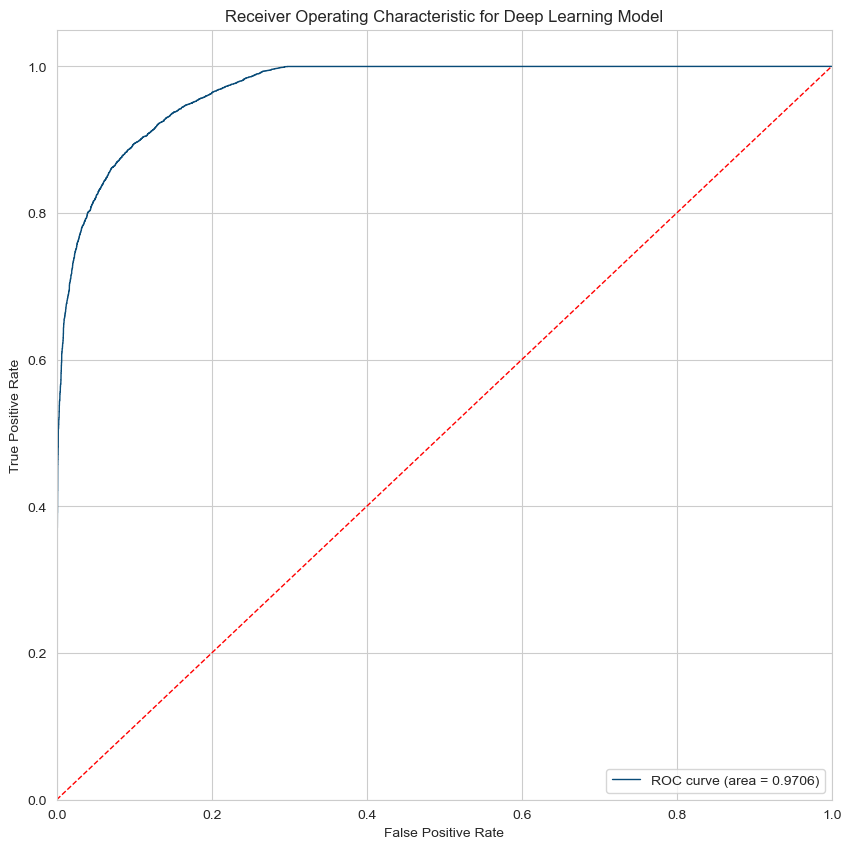

In [65]:
# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_deep, tpr_deep, color='#084b78', lw=1, label='ROC curve (area = %0.4f)' % roc_auc_deep)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Deep Learning Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/ROC_deep_learning_model.png', dpi=200)
plt.show()

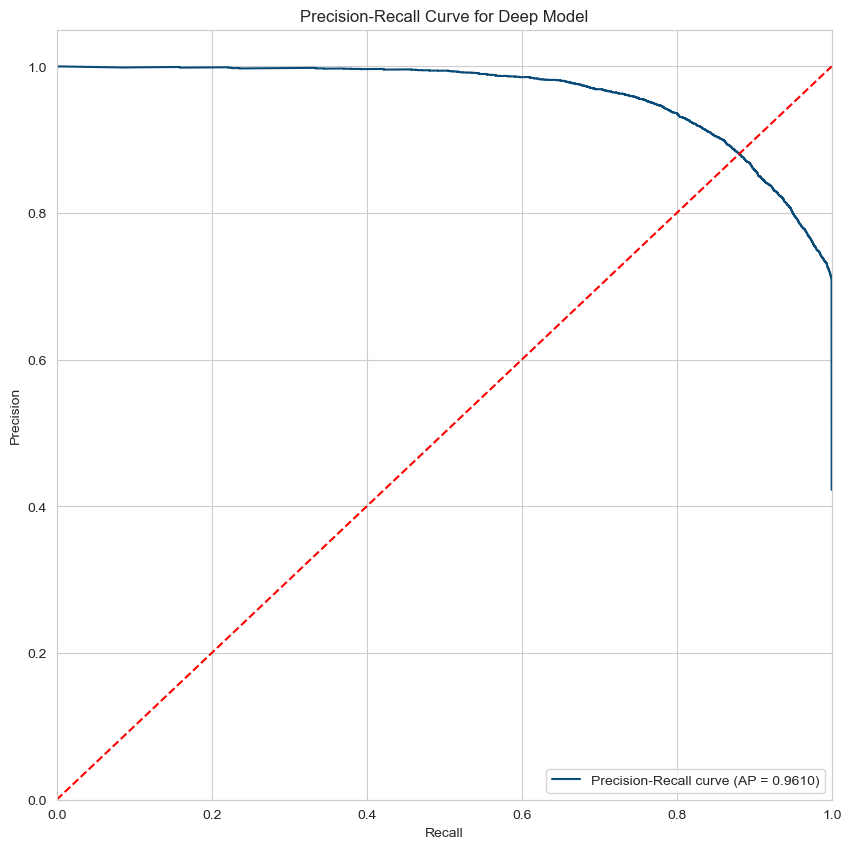

In [66]:
# Plot the precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(recall_deep, precision_deep, color='#084b78',  label='Precision-Recall curve (AP = %0.4f)' % average_precision_deep)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve for Deep Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/precision_recall_curve_deep_learning_model.png', dpi=200)
plt.show()

0.8359701273258692


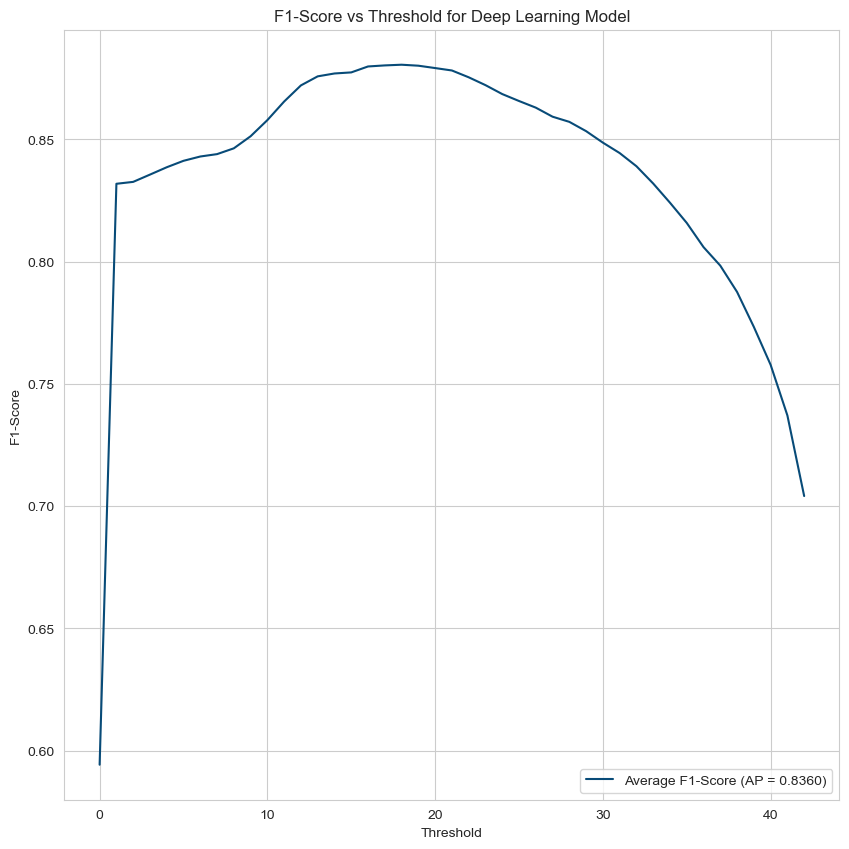

In [67]:
# Plot the F1-score for different threshold values
ave_f1_score_deep = np.mean(f1_scores_deep)
print(ave_f1_score_deep)
plt.figure(figsize=(10, 10))
plt.plot(thresholds_deep1, f1_scores_deep , color='#084b78',  label='Average F1-Score (AP = %0.4f)' % ave_f1_score_deep)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for Deep Learning Model')
plt.legend(loc="lower right")
plt.savefig('./../plot/f1_score_deep_learning_model.png', dpi=200)
plt.show()

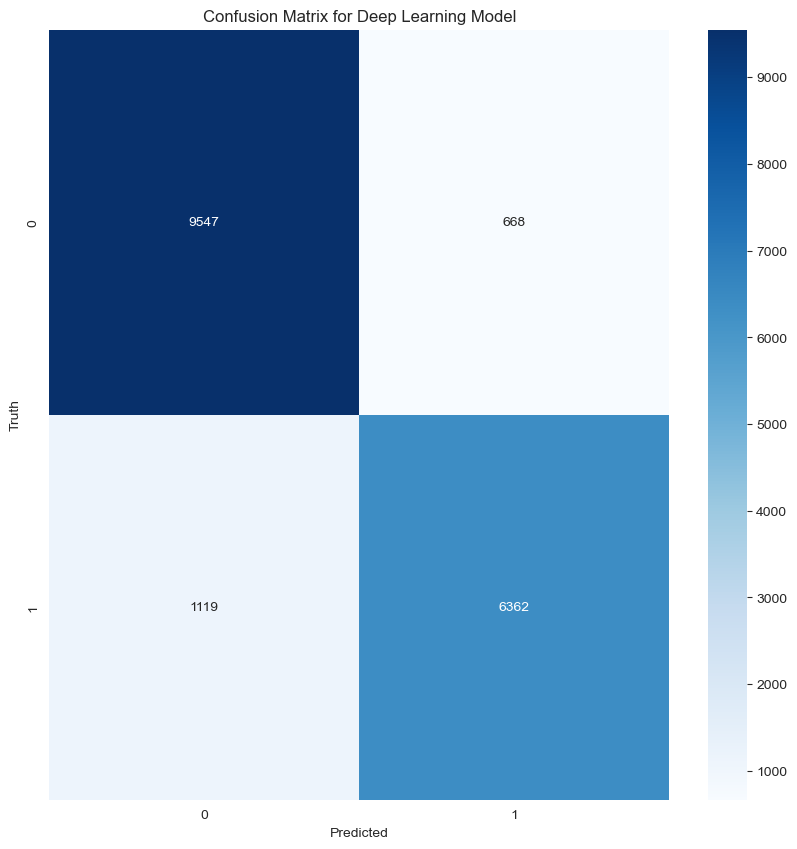

In [68]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Deep Learning Model')
plt.savefig('./../plot/confusion_matrix_deep_learning_model.png', dpi=200)
plt.show()

In [69]:
#Model Evaluating

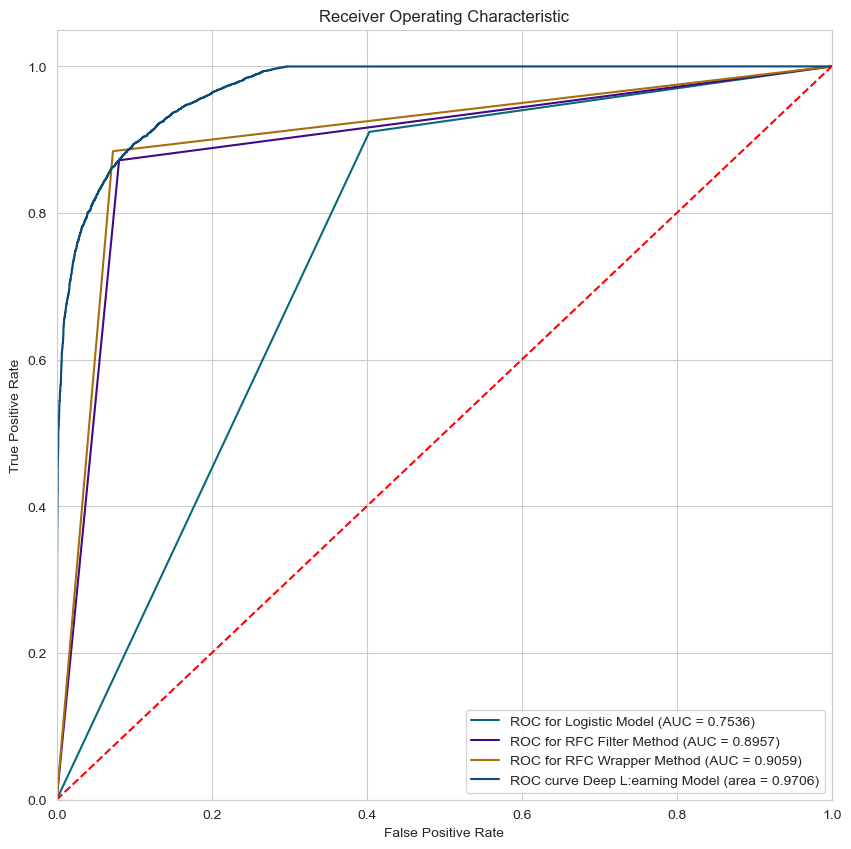

In [70]:
# Plot the ROC curves
plt.figure(figsize=(10, 10))
plt.plot(logistic_fpr, logistic_tpr, color='#086978', label='ROC for Logistic Model (AUC = %0.4f)' % logistic_roc_auc)
plt.plot(fpr_filter, tpr_filter, color='#430887', label='ROC for RFC Filter Method (AUC = %0.4f)' % roc_auc_filter)
plt.plot(fpr_wrapper, tpr_wrapper, color='#a86e0a', label='ROC for RFC Wrapper Method (AUC = %0.4f)' % roc_auc_wrapper)
plt.plot(fpr_deep, tpr_deep, color='#084b78', label='ROC curve Deep L:earning Model (area = %0.4f)' % roc_auc_deep)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./../plot/ROC_model_evaluating.png', dpi=200)
plt.show()

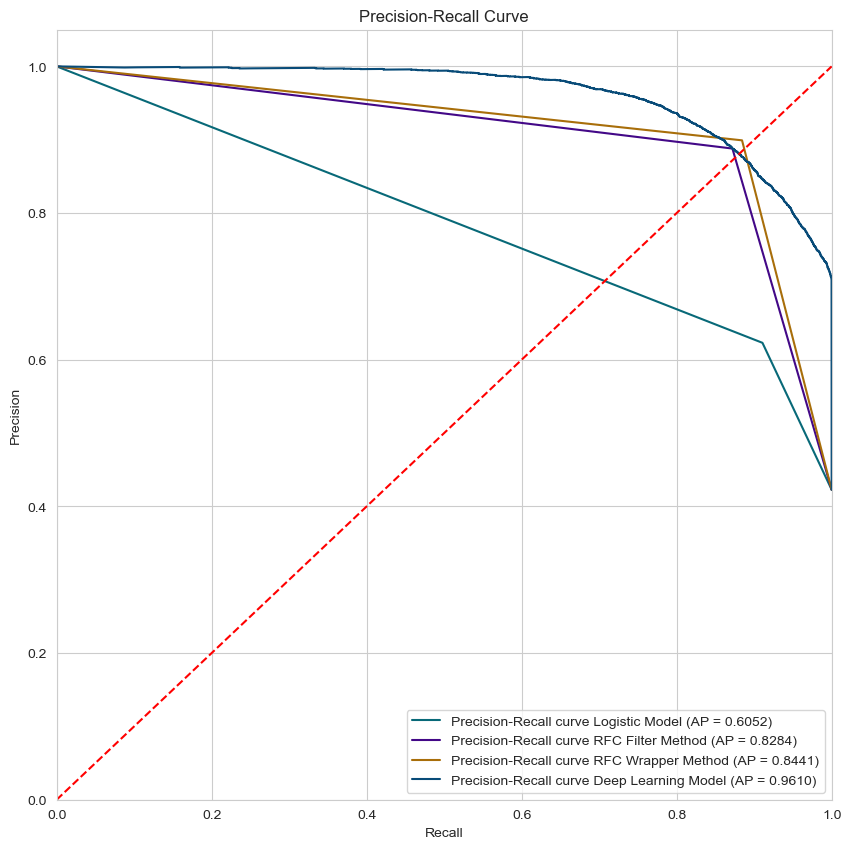

In [71]:
# Plot the precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(logistic_recall,logistic_precision, color='#086978', label='Precision-Recall curve Logistic Model (AP = %0.4f)' % logistic_average_precision)
plt.plot(recall_filter, precision_filter, color='#430887', label='Precision-Recall curve RFC Filter Method (AP = %0.4f)' % average_precision_filter)
plt.plot(recall_wrapper, precision_wrapper, color='#a86e0a', label='Precision-Recall curve RFC Wrapper Method (AP = %0.4f)' % average_precision_wrapper)
plt.plot(recall_deep, precision_deep, color='#084b78', label='Precision-Recall curve Deep Learning Model (AP = %0.4f)' % average_precision_deep)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig('./../plot/precision_recall_curve_model_evaluating.png', dpi=200)
plt.show()

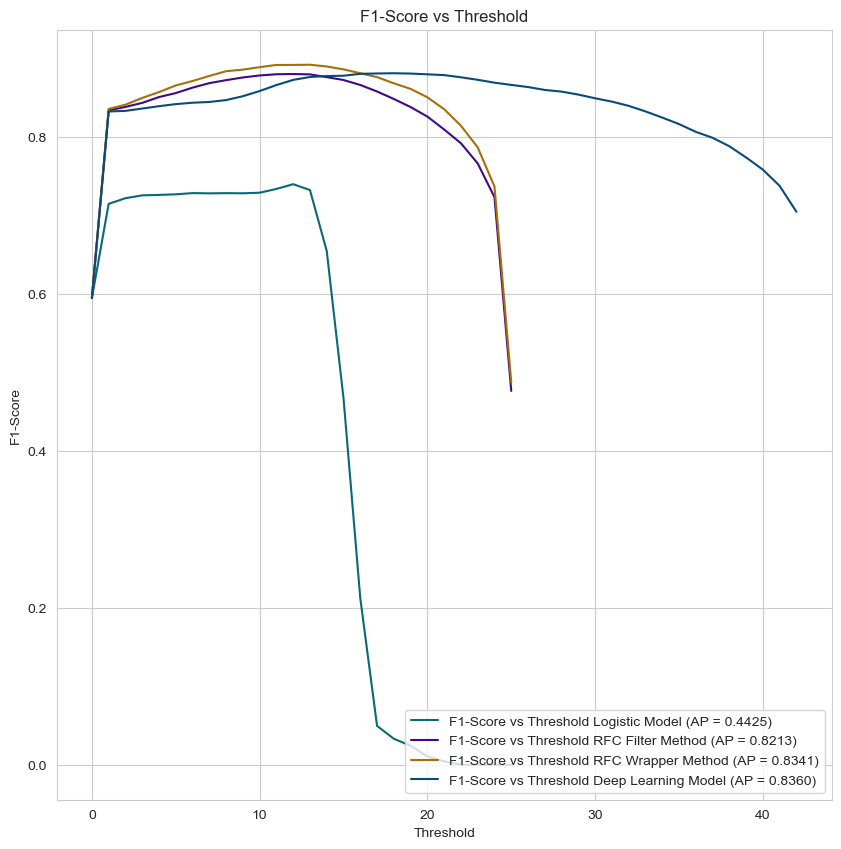

In [72]:
# Plot the F1-score for different threshold values
plt.figure(figsize=(10, 10))
plt.plot(logistic_thresholds, logistic_f1_scores, color='#086978', label='F1-Score vs Threshold Logistic Model (AP = %0.4f)' %  logistic_ave_f1_score)
plt.plot(thresholds_filter, f1_scores_filter, color='#430887', label='F1-Score vs Threshold RFC Filter Method (AP = %0.4f)'  % ave_f1_score_filter)
plt.plot(thresholds_wrapper, f1_scores_wrapper, color='#a86e0a', label='F1-Score vs Threshold RFC Wrapper Method (AP = %0.4f)'  % ave_f1_score_wrapper)
plt.plot(thresholds_deep1, f1_scores_deep, color='#084b78', label='F1-Score vs Threshold Deep Learning Model (AP = %0.4f)'  % ave_f1_score_deep)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend(loc="lower right")
plt.savefig('./../plot/f1_score_model_evaluating.png', dpi=200)
plt.show()

In [73]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

In [76]:
scores = []
for train, val in k_fold.split(X_deep, y_deep):
    # Fit the model
    deep_learning_model.fit(X_train_deep, y_train_deep, epochs=10, batch_size=25, verbose=0)
    # Evaluate the model
    score = deep_learning_model.evaluate(X_val_deep, y_val_deep, verbose=0)
    # Append the scores
    scores.append(score[1])

print('Cross Validation: %.4f' % np.mean(scores))

[0.06594709306955338, 0.9030649662017822]
[0.06492530554533005, 0.9045941233634949]
[0.06701981276273727, 0.9031979441642761]
[0.06603007018566132, 0.9040622115135193]
[0.06964898109436035, 0.9010704159736633]
Cross Validation: 0.9032
Cross Validation: 0.0012
